
## ARIMA
- 자기회귀누적이동평균 모형(AR Integrated MA, ARIMA)는 단변량 정상성 시계열의 예측에 사용하는 대표적인 방법
 
 단변량 vs. 다변량 시계열
 - 분석의 대상이 되는 변수(종속변수)의 개수에 따라 단변량 시계열과 다변량 시계열로 구분

정상성 시계열
- 시계열 데이터의 확률적 특성에 따라 정상성 시계열과 비정상성 시계열로 구분

1. 시계열 정상성 확인
- ADF test의 p-value < 유의수준 : 정상성시계열, 정상성 시계열이 아닌 경우 차분 후 정상성 확인 필요(d 결정됨)
- Ljung-Box test의 p-value < 유의수준 : 백색잡음이 아니므로 모형을 적용하여 개선이 가능, 백색잡음이면 개선 범위 밖이기에 중지
2. 모형 식별
- PACF와 ACF를 사용해서 모형의 차수를 결정(p,q)
3. 모수 추정
- Maximum Likelihood Estimation 적용하여 컴퓨터를 활용한 수치 해석 방법으로 계산
4. 모형 검정
- 예측모형을 적용시키고 잔차의 백색소음 확인(Ljung-Box test의 p-value >= 유의수준)

### 1. 시계열 정상성 확인
1. ADF test
- 단위근: 시계열이 비정상일 때 나타나는 특성으로 단위근이 존재하면 허위적 자기상관이 발생함
- 가설
    - 귀무가설: 단위근 존재 > 시계열은 비정상성
    - 대립가설: 단위근 미존재 > 시계열은 정상성
- 정상 시계열 또는 차분을 통하여 정상화 가능

2. Ljung-Box test
- 백색잡음(white noise): 서로 독립, 평균=0, 분산=모분산(상수) > 잔차의 특성
- 가설
    - 귀무가설: t데이터는 t-1데이터와 자기상관성이 없음: 백색잡음임
    - 대립가설: t데이터는 t-1데ㅔ이터와 자기상관성이 있음: 백색잡음이 아님
- white noise 아님 > 모형을 적용하여 개선이 가능
- white noise 임 > 더이상 모형 적용이 불가

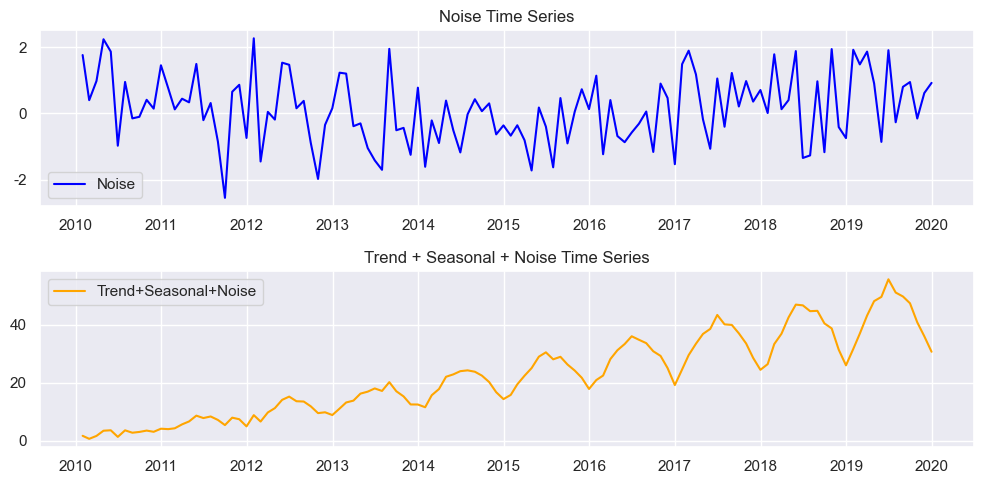

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
n=10*12
np.random.seed(0)
noise=np.random.randn(n) 
trend=np.arange(0,30,30/n)
seasonal=np.array([1,3,5,7,8,9,8,7,6,4,2,0]*(n//12)*trend*0.1)
#시계열 데이터 생성
ts_noise=pd.Series(noise)
ts_trend_seasonal=pd.Series(trend+seasonal+noise)
#시계열 데이터프레임 생성
df=pd.DataFrame({'ts_noise': ts_noise, 'ts_trend_seasonal':ts_trend_seasonal})
#ME= Month End(월말)
df.index=pd.date_range('2010-01-01', periods=n, freq='ME')
#시계열 데이터 시각화
sns.set(style= 'darkgrid')
fig,ax=plt.subplots(2,1,figsize=(10,5))
ax[0].plot(df['ts_noise'],label='Noise',color='blue')
ax[0].set_title('Noise Time Series')
ax[0].legend()
ax[1].plot(df['ts_trend_seasonal'],label='Trend+Seasonal+Noise', color='orange')
ax[1].set_title('Trend + Seasonal + Noise Time Series')
ax[1].legend()
plt.tight_layout()
plt.show()

noise 데이터에 대하여 정상성 확인(ADF 검정)

In [25]:
from statsmodels.tsa.stattools import adfuller
#autolag='AIC', 자동으로 lag(시차)를 AIC 기준으로 가장 좋은 것으로 조정을 해라
p_value= adfuller(ts_noise, autolag='AIC')[1]

if p_value<0.05:
    print(f'{p_value=:.4f}: 정상성 시계열')
else:
    print(f'{p_value=:.4f}: 비정상성 시계열')

p_value=0.0000: 정상성 시계열


noise 데이터를 Ljung-Box test통해 백색소음 여부 확인

In [26]:
from statsmodels.stats.diagnostic import acorr_ljungbox
#lags=1, 바로 전 데이터 사용
#ljungboxtest 시 여러 결과값이 나오는데 lb_pvalue에 p_value값이 들어있다
#.iloc[0]> 여러개의 p_value 중 가장 위의 값을 가져오게 함
p_value=acorr_ljungbox(ts_noise, lags=1)['lb_pvalue'].iloc[0]
print(acorr_ljungbox(ts_noise,lags=1))
if p_value<0.05:
    print(f'{p_value=:.4f}: 백색잡음 아님')
else:
    print(f'{p_value=:.4f}: 백색잡음')

   lb_stat  lb_pvalue
1  0.13292   0.715424
p_value=0.7154: 백색잡음


노이즈 데이터는 ARIMA를 적용시킬 필요 없음(백색잡음임)

ts_trend_seasonal 데이터에 대하여 정상성 확인

In [27]:
from statsmodels.tsa.stattools import adfuller
#autolag='AIC', 자동으로 lag(시차)를 AIC 기준으로 가장 좋은 것으로 조정을 해라
p_value= adfuller(ts_trend_seasonal, autolag='AIC')[1]

if p_value<0.05:
    print(f'{p_value=:.4f}: 정상성 시계열')
else:
    print(f'{p_value=:.4f}: 비정상성 시계열')

p_value=0.9983: 비정상성 시계열


차분을 이용하여 데이터를 정상성으로 바꿔줘야 함

In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox

p_value=acorr_ljungbox(ts_trend_seasonal, lags=1)['lb_pvalue'].iloc[0]
print(acorr_ljungbox(ts_trend_seasonal,lags=1))
if p_value<0.05:
    print(f'{p_value=:.4f}: 백색잡음 아님')
else:
    print(f'{p_value=:.4f}: 백색잡음')

      lb_stat     lb_pvalue
1  114.593828  9.658626e-27
p_value=0.0000: 백색잡음 아님


모형을 적용하여 개선이 가능하다

ts_noise는 백색잡음이므로 시계열 모형이 필요없고, ts_trend_seasonal은 차분 후 정상성이 확인되면 시계열 모형의 적용이 가능하다.

### 2. 모형 식별(ARIMA 모형 차수 결정)
- 자기상관함수(ACF)
    - 시차에 따른 관측치 간의 상관관계를 의미
    - 시차가 증가할수록 상관관계가 감소 > 0으로 수렴
        - 정상성 시계열은 시차가 증가할수록 ACF가 빠르게 감소
        - 비정상성 시계열을 ACF가 느리게 감소
    - 0을 중심으로 하는 신뢰 구간에 포함되면 무작위성을 가정 > 신뢰구간에 진입하는 최초의 시차를 q로 설정
- 편자기상관함수(PACF)
    - 시차가 다른 두 시계열 데이터 간의 순수한 상관관계(편상관)를 의미
    - 시차가 증가할수록 편상관관계가 감소 > 0으로 수렴
    - 0을 중심으로 하는 신뢰구간에 포함되면 무작위성을 가정 > 신뢰구간에 진입하는 최초의 시차를 p로 설정

차분이란?           
이전 시점 값과 현재 시점 값의 차이를 계산하는 것

d 차분
- 선형 추세의 경우: d=1
- 비선형의 경우: d=1 또는 d=2 

| 차분 차수 `d` | 의미            | 예시                                  |
| --------- | ------------- | ----------------------------------- |
| `d = 0`   | 이미 정상 시계열     | 평균이 일정한 진동성 데이터                     |
| `d = 1`   | **선형 추세** 제거  | 예: 매일 조금씩 증가하는 판매량                  |
| `d = 2`   | **비선형 추세** 제거 | 예: 곡선 형태로 증가/감소하는 데이터 (가속도 있는 증가 등) |


AR(p)
- ACF는 0으로 수렴, PACF는 p시차 이후 급격히 감소 - p 결정      

MA(q)
- ACF는 q시차 이후 급격해 감소, PACF는 0으로 수렴 - q 결정      

ARMA(p,q)
- ACF는 q 시차 이후 급격히 감소, PACF는 p 시차 이후 급격히 감소 - p,q 결정      

## 시계열분석 실습
### sktime 라이브러리
- sktime은 시계열 기계학습을 위한 통합 Python 라이브러리
- sktime은 scikit-learn의 프로세스(fit, transform, predict,...)를 그대로 차용
- pandas를 기본 데이터 구조로 사용(numpy도 사용 가능)

1. 필요 패키지 import
2. Data Preparation
- 1. 데이터세트 로드
- 2. 데이터 세트 split(test dataset, [train dat set, vaildation dataset])
- 3. 데이터 전처리(fit_transform)
- 4. 피쳐엔지니어링(독립변수 축소 및 선택, 생성/ fit_transform)
3. Model Definition
- 1. 모델클래스 import
- 2. 모델 객체 생성(하이퍼 파라미터 설정)
- 3. Pipeline 구축
4. 모델 학습(계수값 찾기, fit)
5. Evaluation
- 1. 예측(predict)
- 2. 모델 성능 평가

### 1.1 데이터세트 준비

수진월별 수술현황

In [29]:
import pandas as pd
ts=pd.read_csv(
    '데이터/수진월별_수술현황_의료급여__20250708203742.csv',
    header=1
)
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시점      216 non-null    int64 
 1   월별(1)   216 non-null    object
 2   계       216 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.2+ KB


In [30]:
ts.head()

,시점,월별(1),계
0,2006,1월,5332
1,2006,2월,5714
2,2006,3월,6442
3,2006,4월,5928
4,2006,5월,6250


시계열 데이터로 변환하기(인덱스가 시간 단위의 index)

In [31]:
ts.index=pd.date_range(start='2006-01-01',periods=len(ts), freq='ME')
ts.head()

,시점,월별(1),계
2006-01-31,2006,1월,5332
2006-02-28,2006,2월,5714
2006-03-31,2006,3월,6442
2006-04-30,2006,4월,5928
2006-05-31,2006,5월,6250


인덱스에 시점을 넣어줬으므로 시점과 월별(1) 데이터 삭제

In [32]:
ts.drop(columns=['시점','월별(1)'],inplace=True) #inplace=True: ts데이터 자체를 바꾸도록 설정
#'계' 컬럼명 변경
ts.columns=['수술건수']
ts.head()

,수술건수
2006-01-31,5332
2006-02-28,5714
2006-03-31,6442
2006-04-30,5928
2006-05-31,6250


c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserW

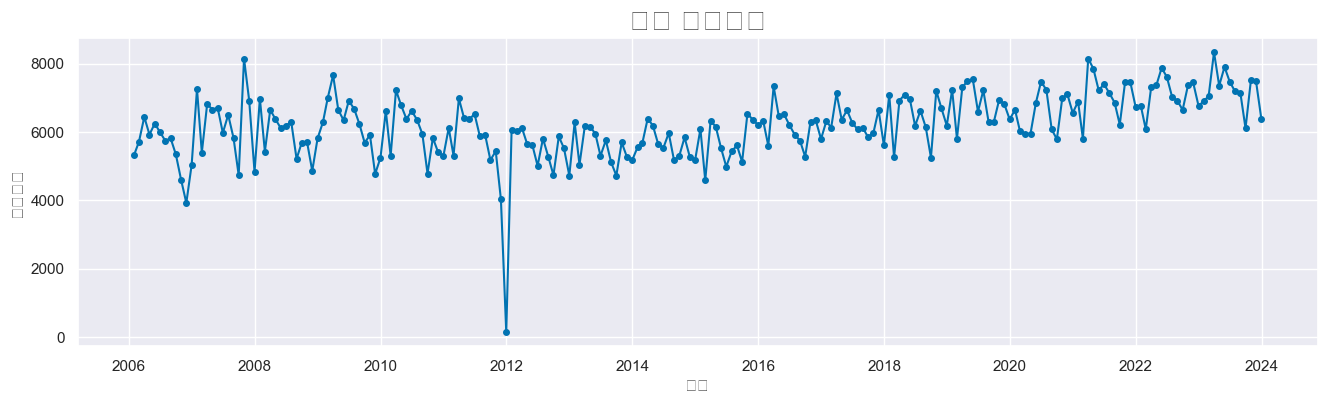

In [33]:
import koreanize_matplotlib
from sktime.utils.plotting import plot_series

#시계열 데이터 시각화
plot_series(ts, title='월별 수술건수', y_label='수술건수',x_label='시점');

### 1.2 데이터세트 split
학습데이터와 평가데이터 분리
- temporal_train_test_split() 사용(sktime)

#Train Data: 180 , #Test Data: 36
--------------------------------------------------------------------------------


c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\s

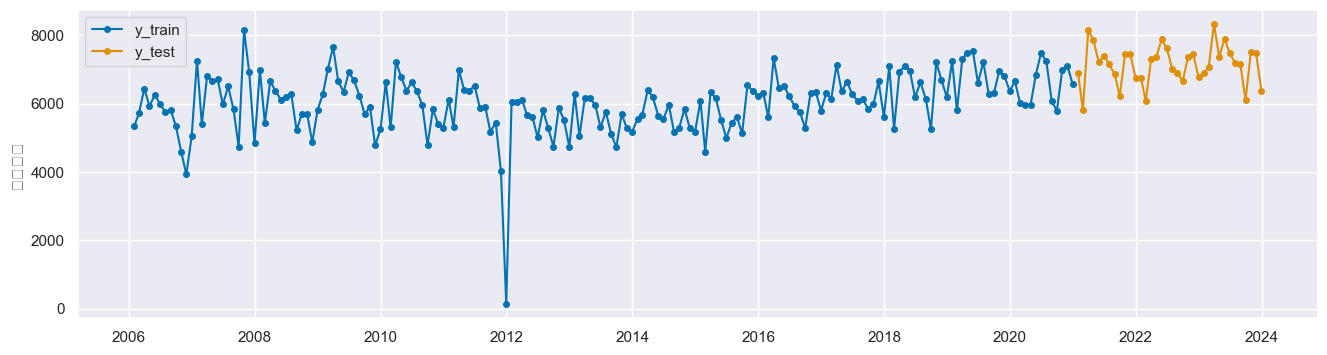

In [34]:
#시계열 데이터세트를 train, test로 나누는 함수
from sktime.forecasting.model_selection import temporal_train_test_split
# 36개월을 test 데이터세트로 사용하고 나머지를 train 데이터세트로 사용
y_train, y_test= temporal_train_test_split(ts,test_size=36)

#데이터세트 개수 확인
print('#Train Data:', y_train.shape[0],', #Test Data:',y_test.shape[0])
print('-'*80)#구분선

#시각화
plot_series(y_train,y_test,labels=['y_train','y_test']);

시간을 인덱스에 넣어줬기 때문에 plot_series를 사용할 때 x값을 따로 넣어주지 않아도 자동으로 설정해준다.

### 예측 시평 성정
- 시평(forecasting horizon)은 예측할 시점의 길이를 의미
- forecasting_horizon을 설정하는 방법은 forecasting 모듈의 ForecastingHorizon 클래스를 사용
    - is_relative는 시평을 어떻게 적용할 것인지 여부
        - Ture: train data이후에 상대적인 시평을 적용
        - False: 지정한 절대적인 시평을 사용

ForecastingHorizon을 절대 시점(is_relative=False)으로 설정하여, 학습 데이터가 끝나는 시점을 기준으로 테스트 데이터의 실제 날짜 인덱스(y_test.index)를 예측 대상으로 지정한다.    
테스트 데이터가 36개월이면, 36개의 절대 시점을 시평으로 설정하게 된다.

In [35]:
from sktime.forecasting.base import ForecastingHorizon

#절대적인 시평을 설정
fh=ForecastingHorizon(y_test.index,is_relative=False)

fh

ForecastingHorizon(['2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', freq='ME', is_relative=False)

### 1.3 데이터 전처리
이상치 처리
- Hampel filter를 이용한 이상치 탐색
    - Hampel filter는 현재 시점 주변 데이터들의 중앙값 대비 얼마나 이상한가를 판단하는 함수로서 일정한 크기의 sliding window를 이용하여 이상치를 탐색
    - 정해진 window구간 내 Median absolute deviation(MdAD)을 구가여 이상치를 판단하고 이상치는 중앙값으로 대체
    

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\s

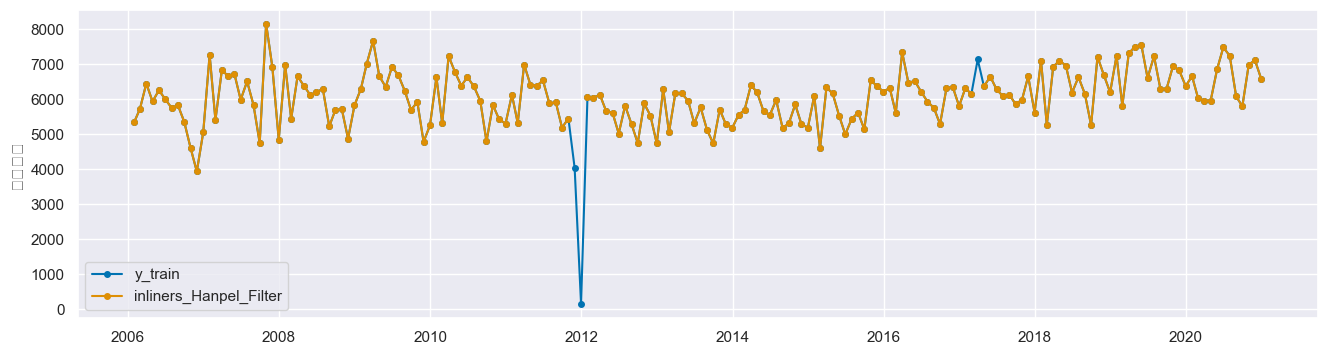

In [36]:
#HapelFilter 클래스 임포트
from sktime.transformations.series.outlier_detection import HampelFilter
#Hampel Filter 객체 생성, n_sigma는 outlier로 판단할 표준편차의 배수
transformer=HampelFilter(window_length=12, n_sigma=3)
#Hampel Filter를 이용하여 이상치 탐지 및 결측치로 대체
y_clean=transformer.fit_transform(y_train)
#시계열 데이터 시각화
plot_series(y_train,y_clean,labels=['y_train','inliners_Hanpel_Filter']);

선형보간법을 이용한 이상치 대체

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\s

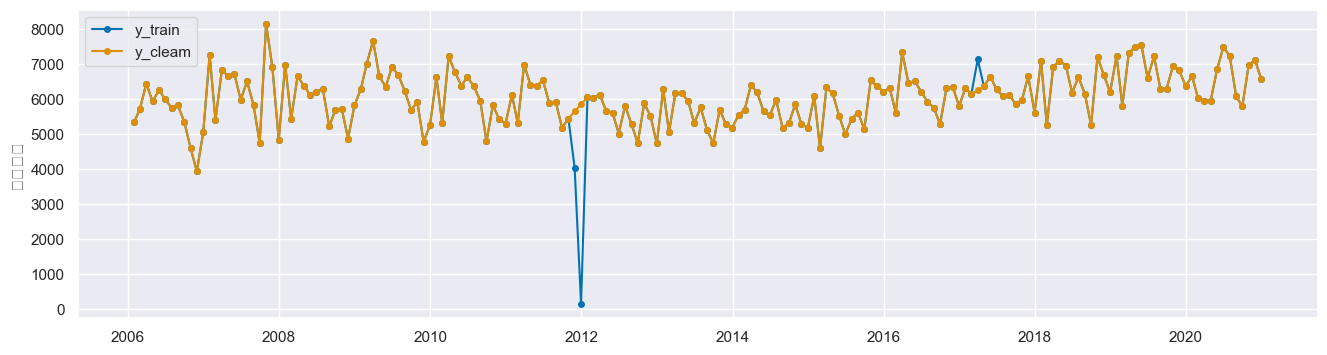

In [37]:
#method='linear':선형보간법, limit_direction='both: 양쪽 데이터 사용
y_clean = y_clean.interpolate(method='linear', limit_direction='both')

#시계열 데이터 시각화
plot_series(
    y_train, y_clean,
    labels=['y_train','y_cleam']
);

### 시계열 정상성 검정
- ADF(단위근 검점)

In [38]:
from statsmodels.tsa.stattools import adfuller
p_value=adfuller(y_clean,autolag='AIC')[1] #[1]이 p_value가 저장된 위치임
if p_value < 0.05:
    print(f'{p_value = :.4f} : 정상성 시계열')
else:
    print(f'{p_value = :.4f} : 비정상성 시계열')

p_value = 0.4804 : 비정상성 시계열


- 비정상성 → 차분 적용

- .diff() 등으로 1차 또는 2차 차분

- 차분 후 ADF 재검정

- 차분한 데이터가 정상인지 확인

In [39]:
#1차 차분 시계열 데이터 생성
y_clean_d1=y_clean.diff(1).dropna()
p_value=adfuller(y_clean_d1,autolag='AIC')[1] 
if p_value < 0.05:
    print(f'{p_value = :.4f} : 정상성 시계열')
else:
    print(f'{p_value = :.4f} : 비정상성 시계열')

p_value = 0.0000 : 정상성 시계열


### 백색잡음 검정
- Ljung-Box test

In [40]:
from statsmodels.stats.diagnostic import acorr_ljungbox
#lags=1, 현재 시점의 값과 1시점 전(이전 시점)의 값 사이의 관계
p_value=acorr_ljungbox(y_clean_d1,lags=1)['lb_pvalue'].iloc[0]
print(acorr_ljungbox(y_clean_d1,lags=1))

if p_value<0.05:
    print(f'{p_value = :.4f}: 백색잡음 아님')
else:
    print(f'{p_value = :.4f}: 백색잡음')

     lb_stat     lb_pvalue
1  43.031448  5.386700e-11
p_value = 0.0000: 백색잡음 아님


### ARIMA 수행

예측모형 성능평가함수 정의
- sktime.performance_metrics.forecasting에서 다양한 성능지표 제공

In [41]:
from sktime.performance_metrics.forecasting import mean_absolute_error as MAE 
from sktime.performance_metrics.forecasting import mean_squared_error as MSE
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as MAPE

#성능평가함수
def evaluate(y_test, y_pred):
    #오차 절대값의 평균
    mae=MAE(y_test,y_pred)
    #오차 제곱의 평균
    mse=MSE(y_test,y_pred)
    #오차 절대값 평균을 percentage로 계산
    mape=MAPE(y_test,y_pred)
    return mae, mse,mape
#결과 저장을 위한 데이터 프레임 생성
results=pd.DataFrame(
    columns=['MAE','MSE','MAPE'] #성능지표
)

ARIMA 모형 차수 결정
- 원 시계열에 대한 ACF와 PACF

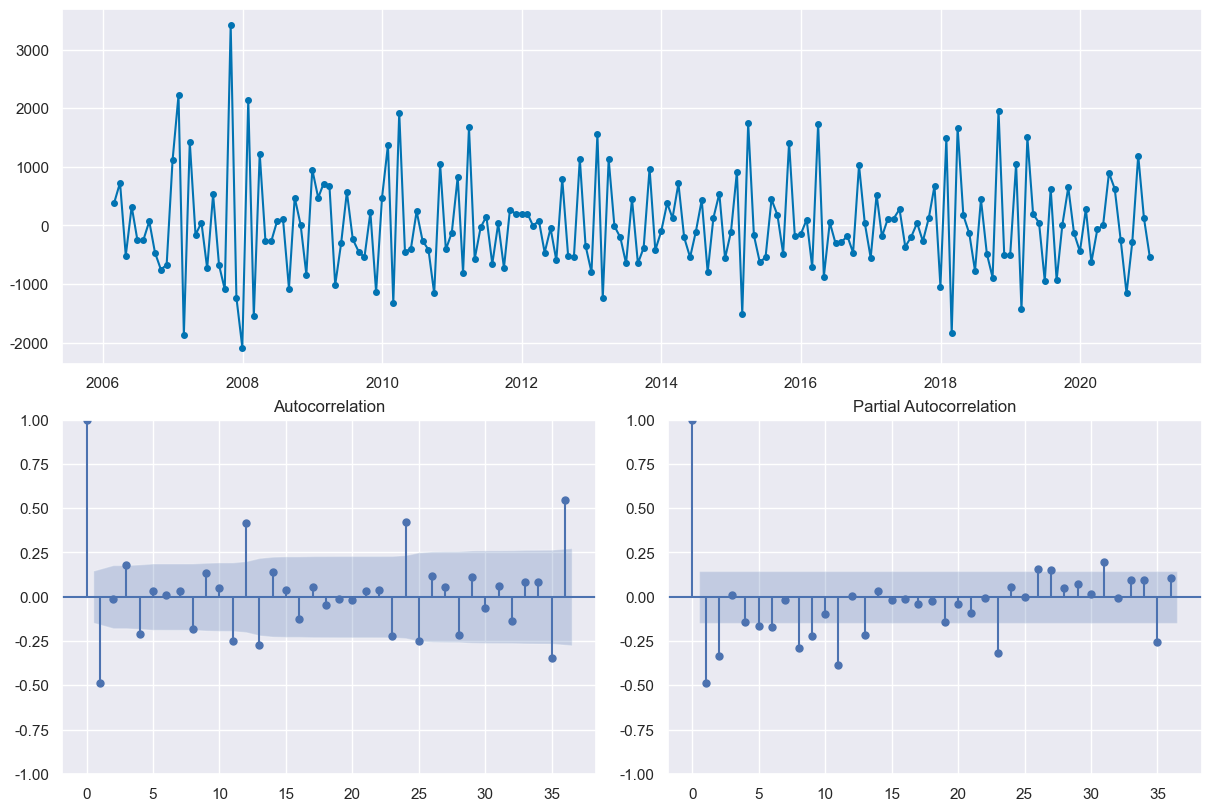

In [42]:
from sktime.utils.plotting import plot_correlations
fig,ax=plot_correlations(y_clean_d1, lags=36)#lags=36: 몇개의 데이터를 볼 것인지 정함

ACF, PACF 둘 다 값이 급변하고 점진적으로 감소하는 게 보이지 않음
- ARMA(p,q)유형인 걸 알 수 있음
- ACF는 q=1 이후로 안정적 > MA(1)
    - q=12 배수에서 피크가 있음 > 계절성 가능성 있음
- PACF는 p=2 이후로 안정적 > AR(2)

ARIMA(2,1,1) 모형으로 예측 가능

In [43]:
from sktime.forecasting.arima import ARIMA
pdq=(2,1,1)

arima=ARIMA(order=pdq)

arima.fit(y_clean)

print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  180
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1427.234
Date:                Tue, 08 Jul 2025   AIC                           2864.468
Time:                        22:40:23   BIC                           2880.405
Sample:                    01-31-2006   HQIC                          2870.931
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.3785     62.107      0.135      0.893    -113.348     130.105
ar.L1         -0.7209      0.238     -3.027      0.002      -1.188      -0.254
ar.L2         -0.3506      0.132     -2.666      0.0

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


- Ljung-Box 검정: Prob(Q): = 0.80 > 유의수준 0.05 → 잔차는 백색잡음 → ARIMA 모형은 적절함
- Heteroskedasticity. Prob(H) = 0.02 < 유의수준 0.05 → 잔차는 이분산성을 가짐 → ARIMA 모형은 적절하지 않음
- Jarque-Bera 검정: Prob(JB) = 0.00 < 유의수준 0.05 → 잔차는 자기상관이 있음 → ARIMA 모형은 적절하지 않음
- Skewness: Skew = 0.54 잔차는 정규분포를 따름
- Kurtosis: Kurtosis = 4.18 → 잔차는 정규분포를 따르지 않음
- 결론: 추정한 ARIMA 모형의 잔차는 이분산성, 자기상관, 비정규분포를 가져 적절한 모형이 아님


### 예측 및 성능평가

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",505.579521,389370.427621,0.070071


c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\s

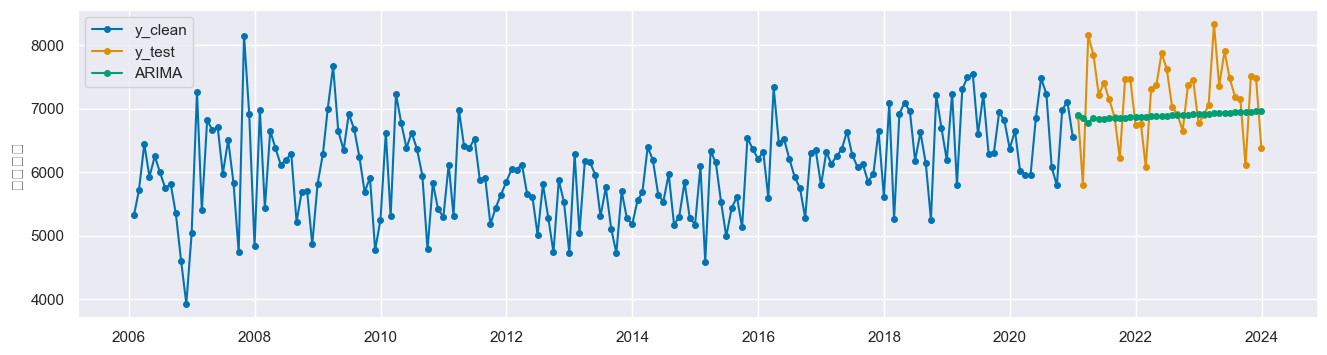

In [44]:
#예측
arima_pred=arima.predict(fh)
fig=plot_series(y_clean,y_test,arima_pred,labels=['y_clean','y_test','ARIMA'])

#성능평가
results.loc['ARIMA'+str(pdq)]=evaluate(y_test,arima_pred)
display(results)

### SARIMA 수행(계절성 반영)

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1294.247
Date:                            Tue, 08 Jul 2025   AIC                           2602.494
Time:                                    22:40:23   BIC                           2624.320
Sample:                                01-31-2006   HQIC                          2611.353
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1435      2.507      0.057      0.954      -4.770       5.057
ar.L1          0.1909      0.091   

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",505.579521,389370.427621,0.070071
"SARIMA(2, 1, 1)",318.024179,141144.578923,0.044373


c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\s

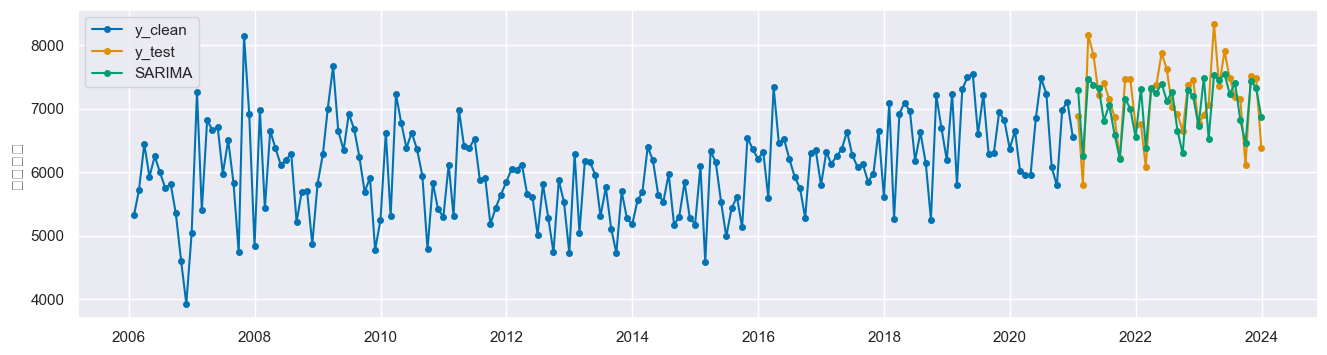

In [45]:
from sktime.forecasting.arima import ARIMA
sarima=ARIMA(order=(2,1,1), seasonal_order=(1,1,1,12))
sarima.fit(y_clean)

print(sarima.summary())

#예측
sarima_pred=sarima.predict(fh)
fig=plot_series(y_clean,y_test,sarima_pred,labels=['y_clean','y_test','SARIMA'])

#성능평가
results.loc['SARIMA'+str(pdq)]=evaluate(y_test,sarima_pred)
display(results)

ar.L2는 유의하지 않기 때문에 order을 (1,1,1)로 바꿔서 수행

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1294.538
Date:                            Tue, 08 Jul 2025   AIC                           2601.075
Time:                                    22:40:24   BIC                           2619.783
Sample:                                01-31-2006   HQIC                          2608.669
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4187      2.310     -0.181      0.856      -4.946       4.108
ar.L1          0.1911      0.088   

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",505.579521,389370.427621,0.070071
"SARIMA(2, 1, 1)",318.024179,141144.578923,0.044373
"SARIMA(1,1,1)",343.000979,159663.144834,0.047514


c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\s

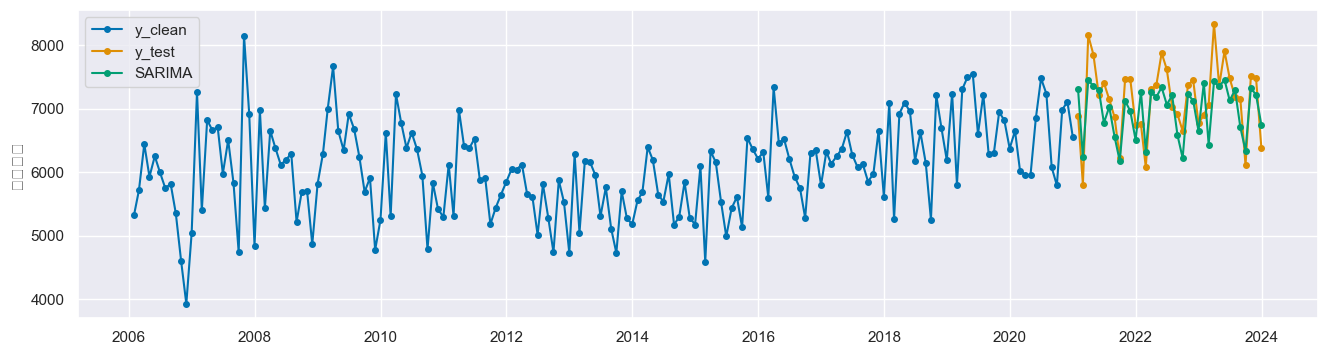

In [46]:
from sktime.forecasting.arima import ARIMA
sarima=ARIMA(order=(1,1,1), seasonal_order=(1,1,1,12))
sarima.fit(y_clean)

print(sarima.summary())

#예측
sarima_pred=sarima.predict(fh)
fig=plot_series(y_clean,y_test,sarima_pred,labels=['y_clean','y_test','SARIMA'])

#성능평가
results.loc[f'SARIMA(1,1,1)'] = evaluate(y_test, sarima_pred)
display(results)

이런 식으로 여러번 차수를 바꿔가며 AIC, BIC 비교를 통해 최적의 모형 결정

AutoARIMA
- ARIMA 모형의 차수를 자동으로 결정

In [47]:
from sktime.forecasting.arima import AutoARIMA

auto_arima=AutoARIMA(max_p=3,max_q=3,sp=12,suppress_warnings=True)

auto_arima.fit(y_clean)
print(auto_arima.summary())

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  180
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1387.531
Date:                              Tue, 08 Jul 2025   AIC                           2793.062
Time:                                      22:40:40   BIC                           2821.749
Sample:                                  01-31-2006   HQIC                          2804.695
                                       - 12-31-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.0052      4.716      0.849      0.396      -5.237      13.247
ar.L1         -0.60

c:\Users\paint\anaconda3\envs\stat\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",505.579521,389370.427621,0.070071
"SARIMA(2, 1, 1)",318.024179,141144.578923,0.044373
"SARIMA(1,1,1)",343.000979,159663.144834,0.047514
AutoARIMA,312.887745,178819.922272,0.044007


c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paint\anaconda3\envs\stat\lib\s

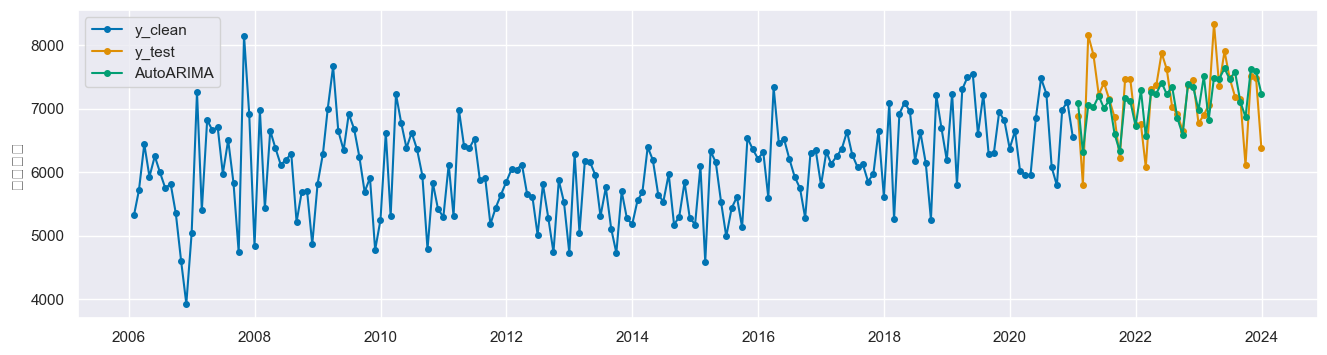

In [48]:
auto_arima_pred=auto_arima.predict(fh)
#예측치 시각화
fig=plot_series(y_clean,y_test,auto_arima_pred,labels=['y_clean','y_test','AutoARIMA'])

results.loc['AutoARIMA']=evaluate(y_test,auto_arima_pred)
display(results)